<a href="https://colab.research.google.com/github/et-tran50/CASE/blob/xgboost/Copy_of_CS_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import shap
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE

In [ ]:
train_data = pd.read_csv('/content/Training Dataset A_R-384922_Candidate Attach #1_PresSE_SRF #1141.csv')
eval_data = pd.read_csv('/content/Evaluation Dataset B_R-384922_Candidate Attach #2_PresSE_SRF #1141.csv')

In [ ]:
# Separate features and target variable
y = train_data['aprv_flag']  # Keep target separately
X = train_data.drop(columns=['aprv_flag'])  # Drop target column
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, stratify=y, random_state=42)


In [ ]:
param_grid = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [len(y_train[y_train == 0]) / len(y_train[y_train == 1])]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=42),
                           param_grid=param_grid, scoring='precision', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Classification Report for Tuned Model:")
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Classification Report for Tuned Model:
              precision    recall  f1-score   support

           0       0.64      0.78      0.70      1696
           1       0.92      0.84      0.88      4786

    accuracy                           0.83      6482
   macro avg       0.78      0.81      0.79      6482
weighted avg       0.84      0.83      0.83      6482



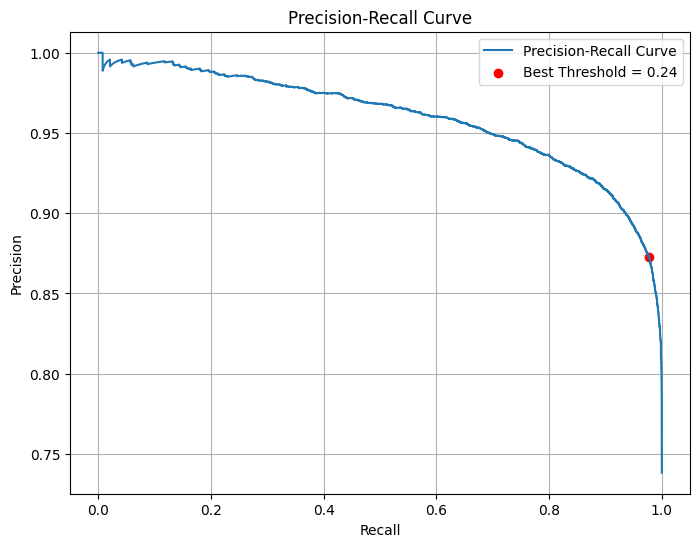

Best Threshold: 0.24089208245277405
Precision: 0.87
Recall: 0.98
F1-Score: 0.92


In [ ]:
# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(X_train)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_train, y_scores)

# Calculate F1-scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Find the threshold with the best F1-score
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.scatter(recall[best_threshold_index], precision[best_threshold_index],
            color='red', label=f"Best Threshold = {best_threshold:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Print best threshold and corresponding metrics
print(f"Best Threshold: {best_threshold}")
print(f"Precision: {precision[best_threshold_index]:.2f}")
print(f"Recall: {recall[best_threshold_index]:.2f}")
print(f"F1-Score: {f1_scores[best_threshold_index]:.2f}")

In [ ]:
# Get predicted probabilities
y_probs = best_model.predict_proba(X_test)[:, 1]

# Set a custom threshold
y_pred_custom = (y_probs >= best_threshold).astype(int)

precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Evaluate performance
print(f"Classification Report with Best Threshold {best_threshold}:")
print(classification_report(y_test, y_pred_custom))

custom_threshold =  0.4  # Adjust this value based on your precision-recall tradeoff
y_pred_custom = (y_probs >= custom_threshold).astype(int)
print('**************')
# Evaluate performance
print("Classification Report with Threshold 4:")
print(classification_report(y_test, y_pred_custom))

precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.87
Recall: 0.96
F1-Score: 0.91
Classification Report with Best Threshold 0.24089208245277405:
              precision    recall  f1-score   support

           0       0.85      0.58      0.69      1696
           1       0.87      0.96      0.91      4786

    accuracy                           0.86      6482
   macro avg       0.86      0.77      0.80      6482
weighted avg       0.86      0.86      0.85      6482

**************
Classification Report with Threshold 4:
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1696
           1       0.90      0.90      0.90      4786

    accuracy                           0.85      6482
   macro avg       0.81      0.81      0.81      6482
weighted avg       0.85      0.85      0.85      6482

Precision: 0.90
Recall: 0.90
F1-Score: 0.90


In [ ]:
# Apply the same preprocessing steps to Dataset B

X_eval = eval_data.drop(columns=['aprv_flag'])  # Separate features and target
y_eval = eval_data['aprv_flag']

X_eval_encoded = pd.get_dummies(X_eval, columns=categorical_cols, drop_first=False)

# Ensure the evaluation data has the same columns as the training data after encoding
X_eval_encoded = X_eval_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Step 8: Evaluate the Model on the Evaluation Dataset
y_eval_pred = best_model.predict(X_eval_encoded)
evaluation_accuracy = accuracy_score(y_eval, y_eval_pred)
print(f"Evaluation Accuracy: {evaluation_accuracy:.4f}")

Evaluation Accuracy: 0.8174


[[ 9.7217804e-01 -8.5644675e-03  1.2366512e-01 ...  1.9120137e-04
   0.0000000e+00 -2.7818768e-04]
 [ 8.6340928e-01 -7.9164039e-03  1.8370874e-01 ...  1.8318451e-04
   0.0000000e+00  1.4255368e-04]
 [ 1.1416914e+00  2.2078771e-02  3.0000794e-01 ...  4.7212196e-04
   0.0000000e+00  2.8223876e-04]
 ...
 [ 2.5160986e-01 -1.1861425e-01 -9.4115865e-01 ...  1.8318451e-04
   0.0000000e+00 -1.4050753e-04]
 [ 7.0516717e-01  5.7899207e-02  2.6690120e-01 ...  1.8318451e-04
   0.0000000e+00 -2.7818768e-04]
 [ 9.8105848e-01  3.2701064e-03 -1.0271628e+00 ...  1.9120137e-04
   0.0000000e+00 -1.4050753e-04]]


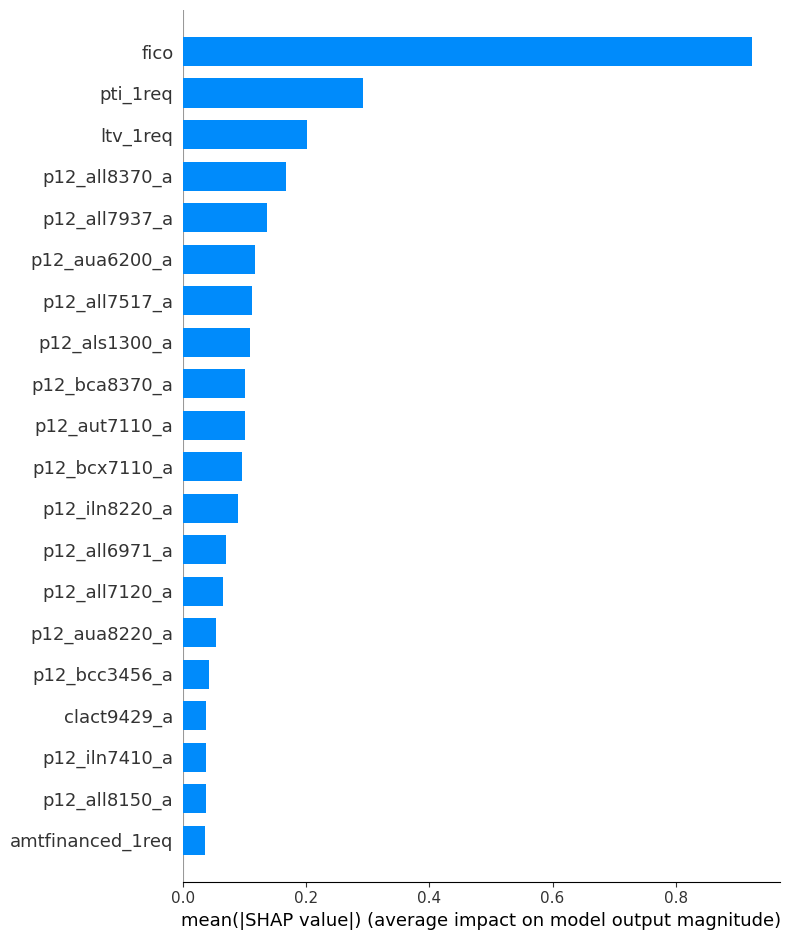

In [ ]:
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)
# Alternatively, use a bar plot to display overall feature importance
shap.summary_plot(shap_values, X_test, feature_names=X_encoded.columns, plot_type="bar")

In [ ]:
print(X_eval.columns)
print(X_train.columns)


Index(['fico', 'amtfinanced_1req', 'collateral_dlrinput_newused_1req',
       'pti_1req', 'ltv_1req', 'p12_reh7120_a', 'p12_bcx7110_a',
       'p12_all7170_a', 'p12_aut7110_a', 'p12_all7120_a', 'p12_all7937_a',
       'p12_bcc8120_a', 'p12_iln7410_a', 'p12_rev1300_a', 'p12_all8150_a',
       'p12_bca8370_a', 'p12_all7517_a', 'p12_iln8220_a', 'p12_all6250_a',
       'p12_aua8151_a', 'p12_rtr7110_a', 'p12_pil8120_a', 'p12_aua0300_a',
       'p12_all7938_a', 'p12_bcc3456_a', 'p12_all8370_a', 'p12_aua8220_a',
       'p12_als1300_a', 'p12_aua6200_a', 'p12_all2427_a', 'p12_alm6200_a',
       'p12_all6971_a', 'clntr9437_a', 'clact9429_a', 'clall5010_a',
       'clall2434_a', 'cloil0214_a', 'cltra4405_a', 'clact9428_a', 'bad_flag',
       'Gender', 'Race'],
      dtype='object')
Index(['fico', 'amtfinanced_1req', 'pti_1req', 'ltv_1req', 'p12_reh7120_a',
       'p12_bcx7110_a', 'p12_all7170_a', 'p12_aut7110_a', 'p12_all7120_a',
       'p12_all7937_a', 'p12_bcc8120_a', 'p12_iln7410_a', 'p12_rev1

In [ ]:
female_customers = X_test[X_test['Gender_Female'] == True]
female_labels = y_test[X_test['Gender_Female'] == True]
male_customers = X_test[X_test['Gender_Male'] == True]
male_labels = y_test[X_test['Gender_Male'] == True]

# Overall dataset predictions
overall_predictions = best_model.predict(X_test)

# Female-specific predictions
female_predictions = best_model.predict(female_customers)

# Female-specific predictions
male_predictions = best_model.predict(male_customers)

In [ ]:
# Overall approval rate. We can sum since the entries are either 0 or 1
overall_approval_rate = sum(overall_predictions) / len(overall_predictions)

# approval rates
female_approval_rate = sum(female_predictions) / len(female_predictions)
male_approval_rate = sum(male_predictions) / len(male_predictions)

print(f"Overall Approval Rate: {overall_approval_rate:.2%}")
print(f"Female Approval Rate: {female_approval_rate:.2%}")
print(f"Male Approval Rate: {male_approval_rate:.2%}")


Overall Approval Rate: 68.10%
Female Approval Rate: 68.82%
Male Approval Rate: 67.45%


In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = [
    [sum(female_predictions), len(female_predictions) - sum(female_predictions)],  # Female approvals/rejections
    [sum(overall_predictions), len(overall_predictions) - sum(overall_predictions)]  # Overall approvals/rejections
]

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared Test p-value: {p:.4f}")
if p < 0.05:
    print("There is a statistically significant difference in approval rates for female customers.")
else:
    print("No statistically significant difference in approval rates for female customers.")


Chi-squared Test p-value: 0.5141
No statistically significant difference in approval rates for female customers.
